<a href="https://colab.research.google.com/github/abhinavgairola/Anomaly_Detection_OTC_Market/blob/main/Scripts/EDA_Machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This peace of code uses Logistic regression and Sklearns GridSearchCV, pipeline capabilities to train and tweak XgBoost and Logistic regression classifier. The aim is to understand which features contributes towards a potential pump and dump scheme--stock sentiments are a serious driver. However in a portfolio of stocks which stocks are pumped the most can also be understood.

In [2]:


def pipeline_creator(model):
  """
  Pipeline creator method
  """

  pipe = Pipeline([('scaler', StandardScaler()), ('classifier',model)])

  return pipe

def XgboostClassifier(X_test,y_test,X_train,y_train):
  """
  Method to train a basic Xgboost classifier-- essentially a wrapper for my own purpose around the scikit learn methods
  This is without any optimization
  """
  model = xgboost.sklearn.XGBClassifier()

  pipe = pipeline_creator(model)#Pipeline([('scaler', StandardScaler()), ('classifier',model)])

  pipe.fit(X_train,y_train)

  y_pred = pipe.predict(X_test)

  probabilities = pipe.predict_proba(X_test) ## Get prediction probabilities to be used in roc_curve methods

  accuracy = accuracy_score(y_test, y_pred)

  print("Accuracy{}".format (accuracy * 100.0))

  tpr_1, fpr_1, threshold_1 = roc_curve(y_test, probabilities[:,0]) ## Positivety and False positivity rate for class 0

  fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:,1]) ## Positivety and False positivity rate for class 1

  precision, recall, threshold = precision_recall_curve(y_test, probabilities[:,0])




  return [tpr_1,fpr_1,fpr_2,tpr_2,y_pred,model,pipe, precision, recall]












In [3]:
#https://xgboost.readthedocs.io/en/latest/parameter.html
## Optimizing the model using GridSearchCV


def predict_fit( model,folds, params_,metric, X_train, y_train, X_test, y_test):

  """
  This method use gridsearchcv to optimize around the supplied parameters, fit, predict, compute accuracy, precision, recall and roc curve

  """




  grid = GridSearchCV(model, params_, cv=folds, scoring=metric)

  grid.fit(X_train, y_train)

  if ((type(model)).__name__) == 'LogisticRegression':
    feature_importance = grid.best_estimator_.coef_
  
  elif ((type(model)).__name__) != 'LogisticRegression':
    feature_importance = grid.best_estimator_.feature_importances_

  y_pred = grid.best_estimator_.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)

  probabilities = grid.predict_proba(X_test)## Class prediction probabilities.

  tpr_1, fpr_1, threshold_1 = roc_curve(y_test, probabilities[:,0]) ## Positivety and False positivity rate for class 0

  fpr_2, tpr_2, threshold_2 = roc_curve(y_test, probabilities[:,1]) ## Positivety and False positivity rate for class 1

  precision, recall, threshold = precision_recall_curve(y_test, probabilities[:,0])

  return {'tpr_1':tpr_1,'fpr_1':fpr_1,'fpr_2':fpr_2,'tpr_2':tpr_2,'predictions':y_pred,'model':grid.best_estimator_,'accuracy':accuracy, 'precision':precision, 'recall':recall,'feature_importance':feature_importance}


#params = {'learning_rate':[0.1,0.2,0.3],'max_depth':[5,6,7]} ## I am optimizing the XgBoost using the maximum depth and the learning rate. Hyper parameter tuning is an art.

#model = xgboost.sklearn.XGBClassifier()

#Output = predict_fit(model,6,params,'recall',X_smote,y_smote,X_test,y_test)
## Pipeline is erroring out for the time being it is fine to use GridSearchCV with XGBoost.
#pipe = pipeline_creator(model)
#grid = search_params(pipe, params, 6, 'precision')
#grid
#grid.fit(X_train,y_train)
#acc = predict(grid,X_train,y_train, X_test, y_test)
#print("Accuracry is {}".format(acc))
#parameter_tuning(pipe,params,6,'precision',X_test,y_test,X_train,y_train)

In [4]:
!pip install shap

     |████████████████████████████████| 358kB 4.1MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491623 sha256=021ad5caa60dafb2ff8e3e5a577abd140f06f3b329a5a6219079e7477c262608
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [5]:
!pip install pycaret

     |████████████████████████████████| 266kB 5.5MB/s 
     |████████████████████████████████| 14.2MB 354kB/s 
     |████████████████████████████████| 276kB 45.5MB/s 
     |████████████████████████████████| 112kB 51.6MB/s 
     |████████████████████████████████| 6.8MB 40.9MB/s 
     |████████████████████████████████| 245kB 51.7MB/s 
     |████████████████████████████████| 174kB 49.8MB/s 
     |████████████████████████████████| 2.0MB 35.5MB/s 
     |████████████████████████████████| 61kB 6.7MB/s 
     |████████████████████████████████| 81kB 9.4MB/s 
     |████████████████████████████████| 1.4MB 45.6MB/s 
     |████████████████████████████████| 1.7MB 32.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 163kB 47.0MB/s 
     |████████████████████████████████| 1.1MB 27.7MB/s 
     |████████████████████████████████| 81kB 7.7MB/s

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import xgboost## Just for checking the help on xbhoost later on
#from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
## pipeline to combine normalizing and model fitting at once
from sklearn.pipeline import Pipeline
## for model optimization
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, precision_recall_curve,average_precision_score, auc
from pycaret.classification import * 

In [8]:
import shap

In [9]:
import csv
from pycaret.classification import *
import math
import pandas as pd
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
data = {}
with open('/content/drive/MyDrive/OTCMKT/Final_data.csv') as f:
  csv_file = csv.DictReader(f)
  for idx,row in enumerate(csv_file):
    data[idx]=(dict(row))  

In [10]:
df = pd.DataFrame(data)

In [11]:
df=df.reset_index()

In [12]:

df = df.T
columns = df.loc['index',:]
df = df.drop('index',axis=0)
df = df.rename(columns=columns)

In [13]:
df = df.set_index('Date')


In [14]:
df = df.replace('', '0')


In [15]:
columns = list(df.columns)

In [16]:
columns.remove('Ticker_name')

In [17]:
columns

['Indicator', 'Price', 'Sentiment_Score', 'Tweet_counts', 'Volume']

In [18]:
df[columns]=df[columns].astype(float)

In [19]:
columns.remove('Indicator')
#columns.remove('Price')
#columns.remove('Volume')

In [20]:
df['Price'] = list(df.Price.add(1*10**-4).apply(lambda x: math.log10(x) ).values)
df['Volume'] = list(df.Volume.add(1*10**-4).apply(lambda x: math.log10(x) ).values)
df['Tweet_counts'] = list(df.Tweet_counts.apply(lambda x: math.log10(x) ).values)

In [21]:
columns

['Price', 'Sentiment_Score', 'Tweet_counts', 'Volume']

##Dataset is not *normalized*

In [22]:
from sklearn import preprocessing
print(columns)
x = df[columns].values 
Minmax_scaler = preprocessing.MinMaxScaler()# scale to 0 and 1
Standard_scaler = preprocessing.StandardScaler()
x_scaled = Minmax_scaler.fit_transform(x)
#x_scaled_transform = Standard_scaler.fit_transform(x_scaled)
df_new = pd.DataFrame(x_scaled)
df_new.columns = columns

['Price', 'Sentiment_Score', 'Tweet_counts', 'Volume']


In [23]:
df_new['Indicator'] = list(df.Indicator.values)

df_new['Tickers'] = list(df.Ticker_name.values)
df_new = df_new.set_index(df.index)

In [24]:
columns = list(df_new.columns)
columns.remove('Tickers')

columns_2 = list(df.columns)
columns_2.remove('Ticker_name')

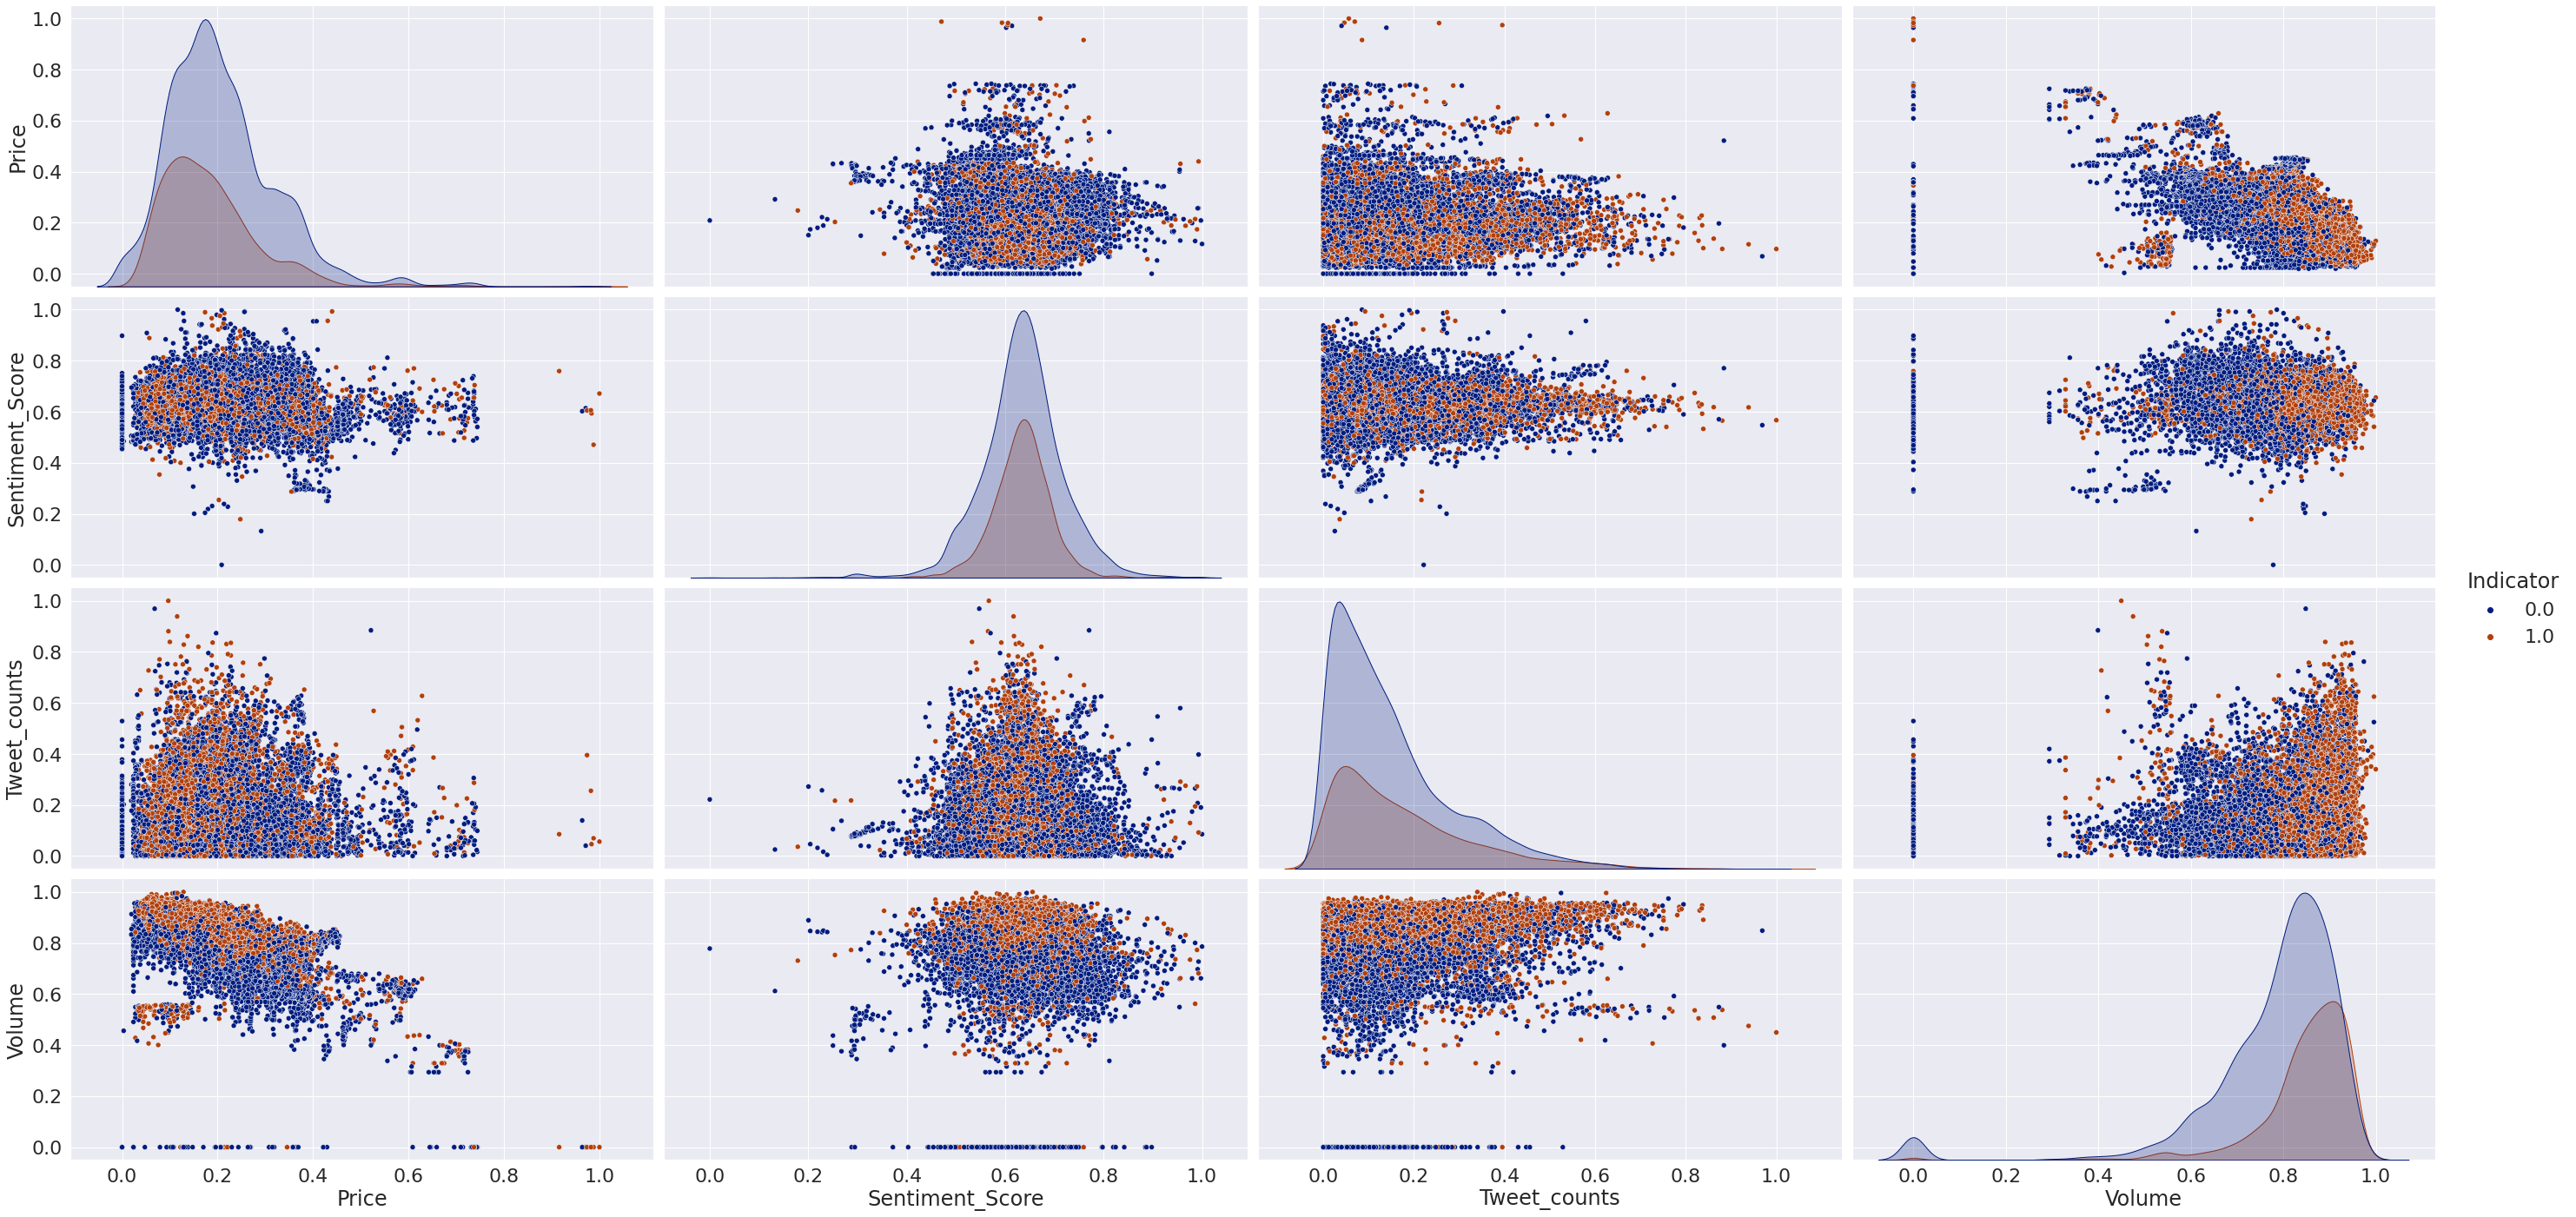

In [25]:
sns.set(font_scale = 2)
sns.pairplot(df_new[columns], hue='Indicator',height=5, 
    aspect=2,palette='dark')


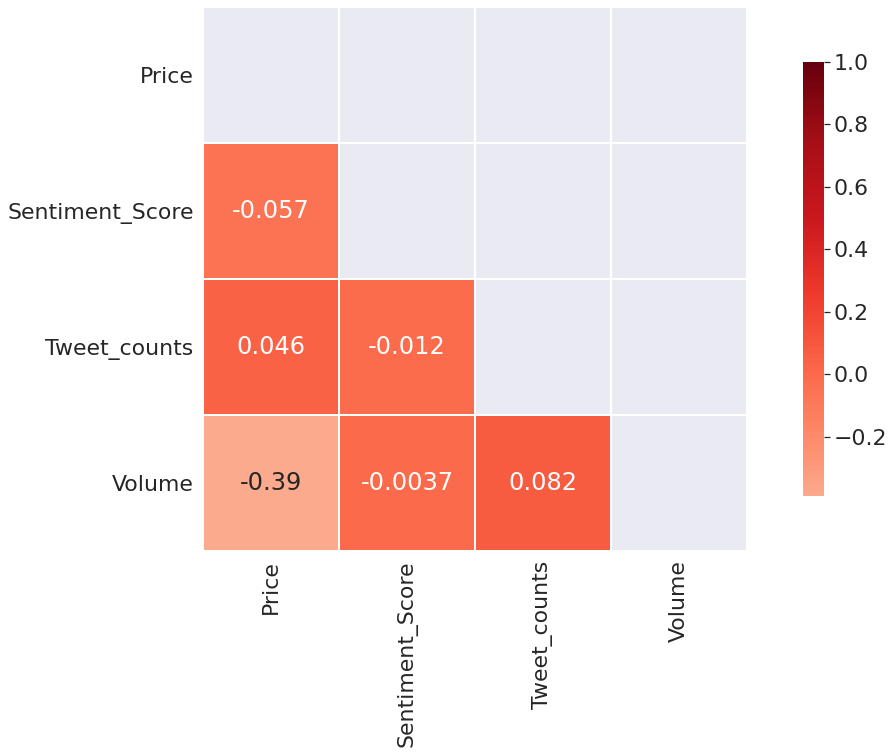

In [26]:
corr = df_new.drop('Indicator',axis=1).corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize = (20,10))
sns.heatmap(corr, mask=mask, cmap='Reds', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True,)

In [27]:
#plt.scatter(df.Tweet_counts,df.Volume,c=df.Ticker_name.astype('category').cat.codes,s=df.Sentiment_Score)
#import plotly.express as px


#fig = px.scatter(df_new.filter(like='2016',axis=0).reset_index(), x="Price", y="Volume",
	        # size="Tweet_counts", color="Tickers",
           #      hover_name="Tickers", log_x=True,log_y=True, size_max=60)#,animation_frame='Date')
#fig.show()

## No collinearity is seen

## Some relationship between the numerical and categorical variables can be check using the catplot or the box and whisker plots or the violin plot. I will use the later. 

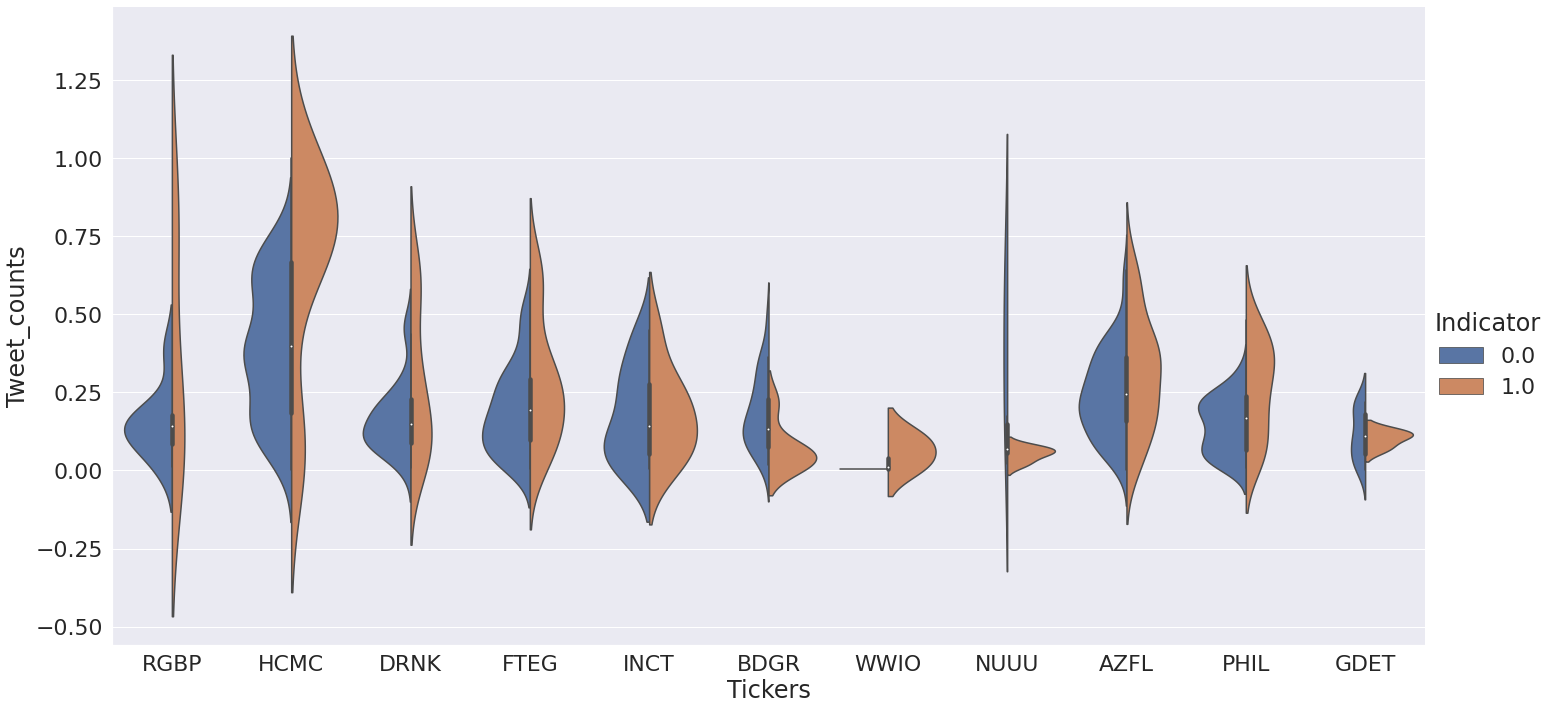

In [28]:

sns.catplot(
    data=df_new[0:500],
    x='Tickers',
    y='Tweet_counts',
    hue='Indicator',
    kind='violin',split=True,
    height=10,
    aspect=2)


## Tweet counts jumps to a higher number as the indicator switches to 1 from 0 for different tickers (in the case of the first 11 tickers in the dataframe). The reason can be a lot of people suddenly start to talk about the stocks owing to a surge in the price.

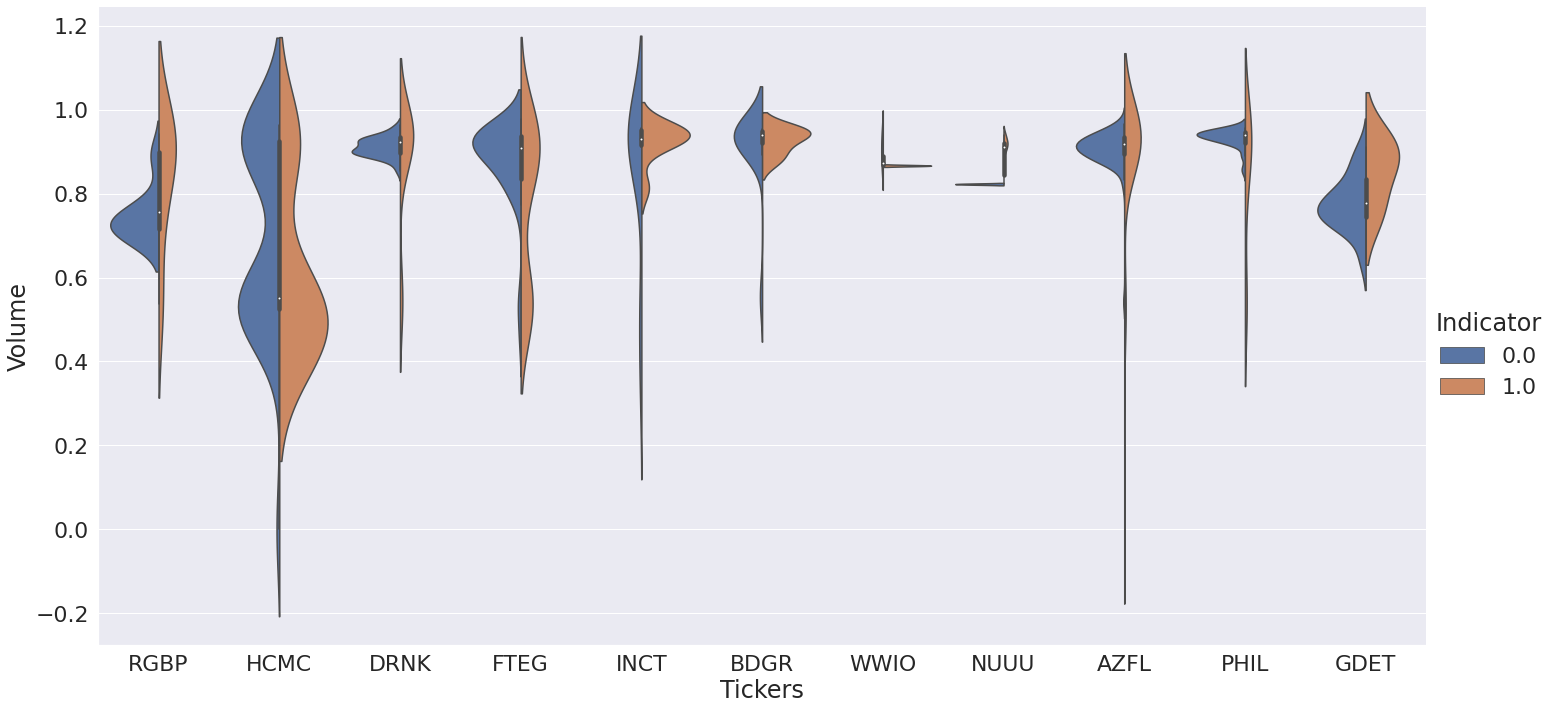

In [29]:
sns.catplot(
    data=df_new[0:500],
    x='Tickers',
    y='Volume',
    hue='Indicator',
    kind='violin',split=True,
    height=10,
    aspect=2)

## The traded volume increases (in the case of the first 4 tickers in the dataframe) too whenever the tweet counts jumps except in the case of the ticker 'HCMC'

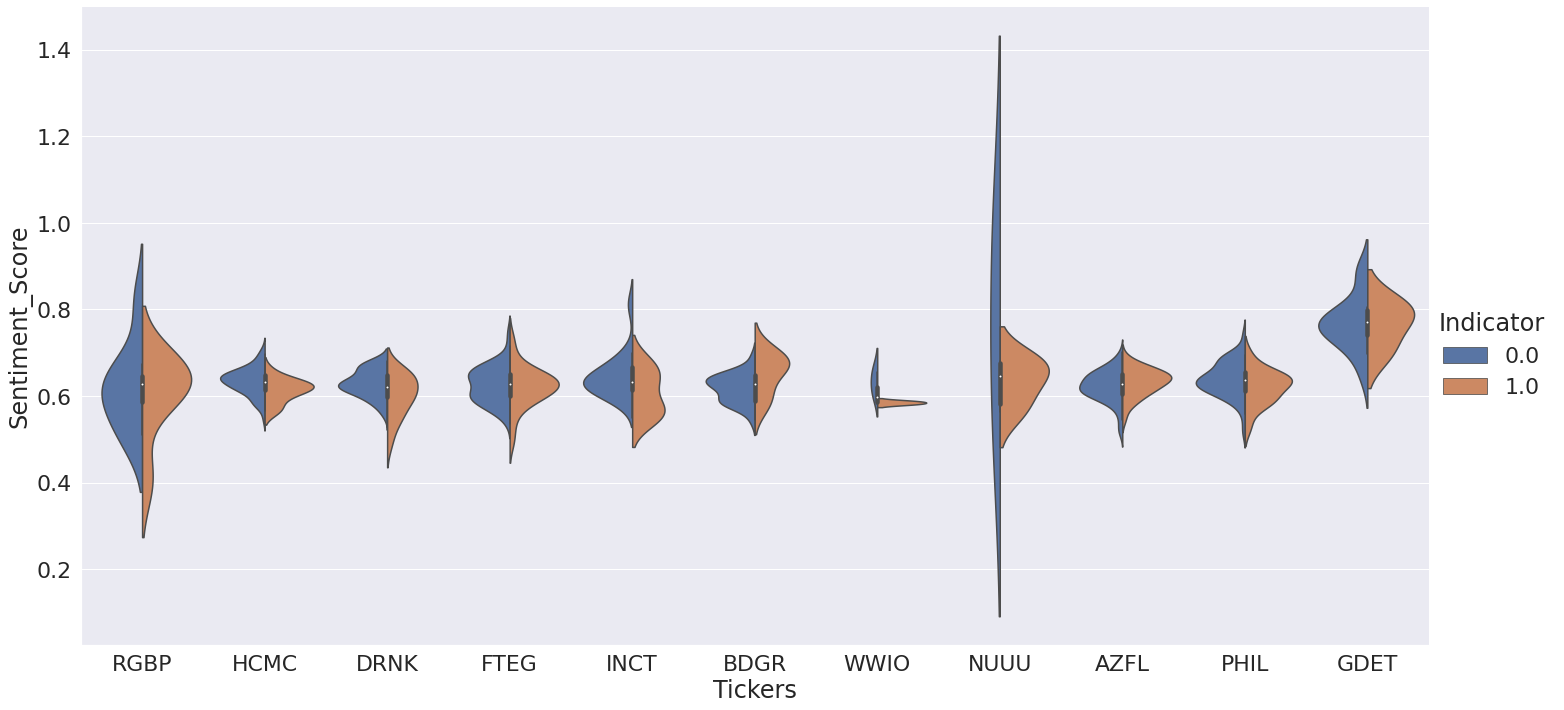

In [30]:
sns.catplot(
    data=df_new[0:500],
    x='Tickers',
    y='Sentiment_Score',
    hue='Indicator',
    kind='violin',split=True,
    height=10,
    aspect=2)

## It seems like (at least after looking at the sentiment scores of the first 11 tickers in the dataframe) that the sentiment score is higher when everything is normal about a particular stock. This makes sense as the pumper may try to create positive sentiments before the pump and dump scheme begins.

In [31]:
#df_new = df_new.drop(['Price','Volume','Tickers'],axis=1)
df_new = df_new.drop('Tickers',axis=1)
df_new

Price  Sentiment_Score  Tweet_counts    Volume  Indicator
Date                                                                    
2016-09-16  0.251436         0.667164      0.126617  0.724977        0.0
2016-09-20  0.249470         0.821066      0.387371  0.749379        0.0
2016-09-21  0.245789         0.634202      0.148820  0.712271        0.0
2016-09-22  0.248953         0.580405      0.182237  0.736265        0.0
2016-09-29  0.246250         0.604957      0.133775  0.701186        0.0
...              ...              ...           ...       ...        ...
2016-05-24  0.228539         0.656598      0.263197  0.686625        0.0
2016-05-27  0.223294         0.584948      0.314651  0.664243        0.0
2016-05-31  0.227339         0.662681      0.335887  0.745497        0.0
2016-06-01  0.236177         0.816727      0.467127  0.747012        1.0
2016-06-24  0.226308         0.701638      0.139354  0.691321        0.0

[14819 rows x 5 columns]

In [32]:
cm = sns.light_palette("green", as_cmap=True)
from IPython.display import display,HTML
HTML((df[df.Ticker_name=='HCMC'].reset_index(drop=False).drop('Indicator',axis=1).head(50).sort_values(by='Date',ascending=True).style.bar(subset=['Sentiment_Score','Volume','Price','Tweet_counts'],color='#FF6500').render()))#\
#.set_table_attributes('border="1" class="dataframe table table-hover table-bordered"') \
#         .set_precision(3) \
#         .render()

#with open('/content/drive/MyDrive/OTCMKT/table.html', 'w') as f:
#    f.write(html)


## Generate dummy values and perform minority class over sampling to account for any imbalances in the predictor feature.


In [33]:
df_xgboost = df_new #pd.get_dummies(df_new)
y = df_xgboost.Indicator
columns_x = list(df_xgboost.columns)
columns_x.remove('Indicator')
X = df_xgboost[columns_x]

sm = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [34]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
LogisticRegressionCV._get_param_names()
model_lr = LogisticRegression()
lr_params = {'penalty':['elasticnet'],'random_state':[0],'max_iter':[1000],'solver':['saga'],'l1_ratio':[0.1]}
Output_lr = predict_fit(model_lr,6,lr_params,'recall',X_smote,y_smote,X_test,y_test) 
#grid.fit(X_smote, y_smote)
dir(model_lr)
((type(model_lr)).__name__)
Output_lr.keys()
y_pred_lr = Output_lr['model'].predict(X_test)
proba_lr = Output_lr['model'].predict_proba(X_test)
tpr_1_lr, fpr_1_lr, threshold_1_lr = roc_curve(y_test, proba_lr[:,0])
fpr_2_lr, tpr_2_lr, threshold_2_lr = roc_curve(y_test, proba_lr[:,1])


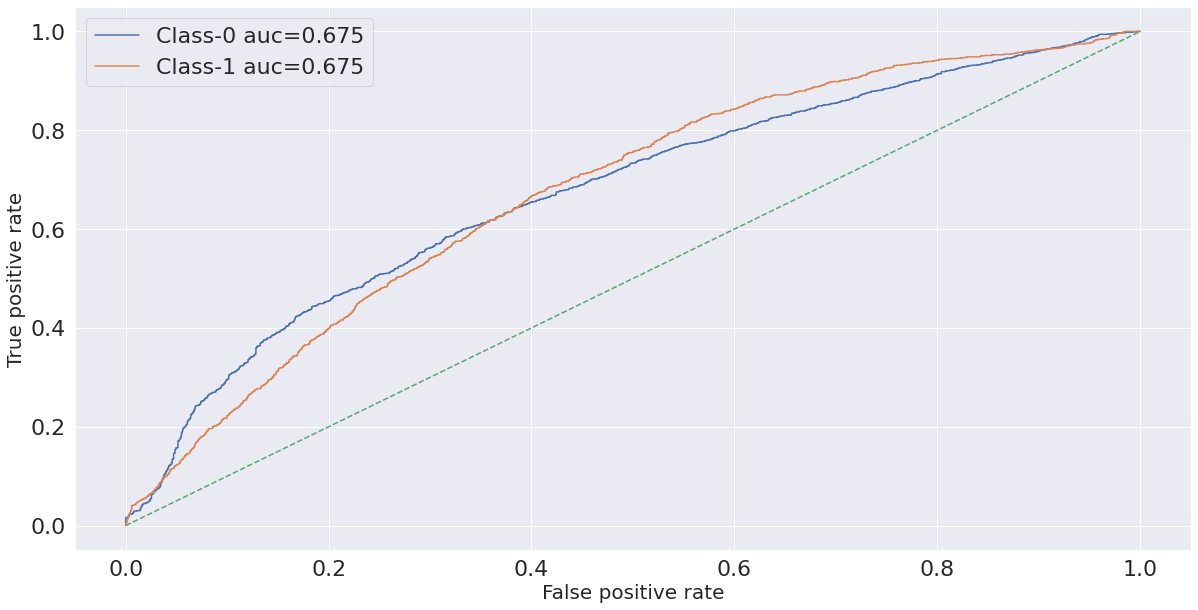

In [35]:
plt.figure(figsize=(20,10))
plt.plot(fpr_1_lr,tpr_1_lr,label='Class-0 auc='+str(round(auc(fpr_1_lr,tpr_1_lr),4)))
plt.plot(fpr_2_lr,tpr_2_lr,label='Class-1 auc='+str(round(auc(fpr_2_lr,tpr_2_lr),4)))
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--')
plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)
plt.legend(loc='best')

Text(146.5, 0.5, 'True')

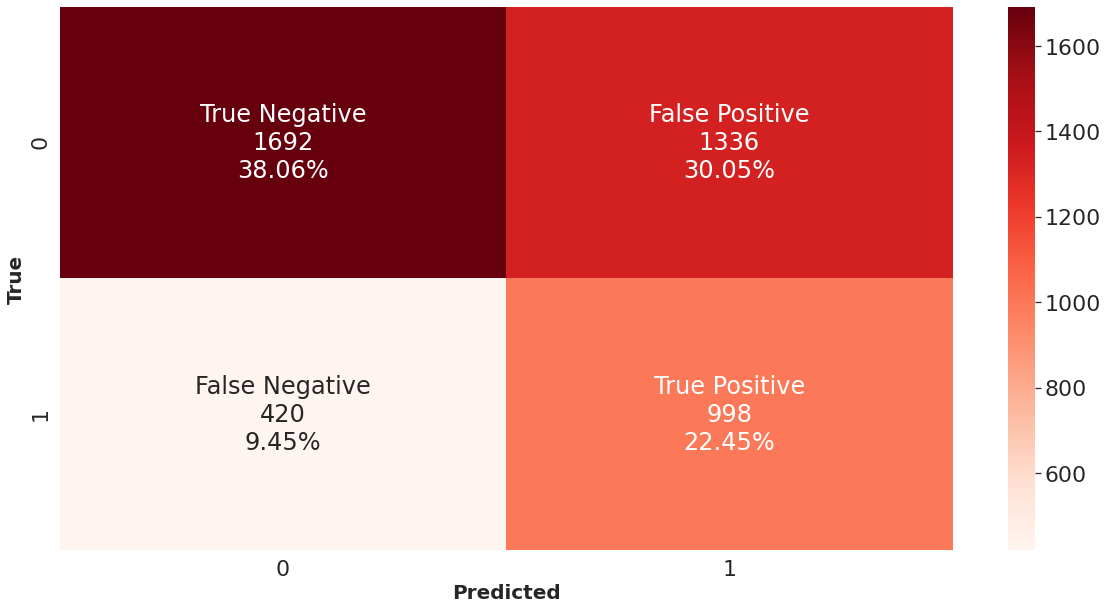

In [36]:
labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,y_pred_lr)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(20,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')

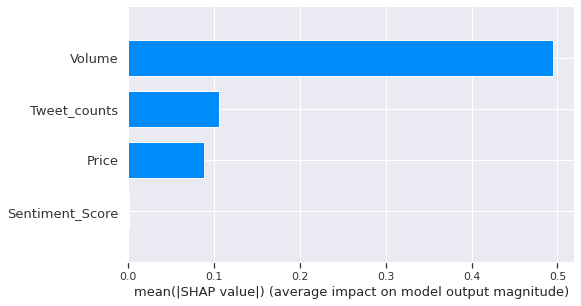

In [37]:

explainer = shap.LinearExplainer(Output_lr['model'],X_smote)#, X_train, feature_dependence="independent")
Shap_values = explainer(X_test)
shap.summary_plot(Shap_values, X_smote, plot_type="bar",plot_size=0.8)


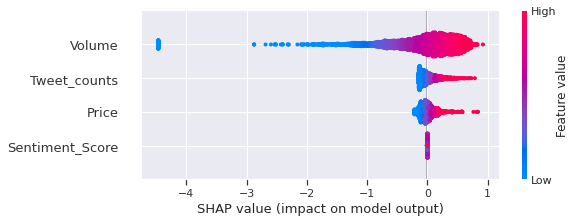

In [38]:
shap.plots.beeswarm(Shap_values)

## I will use scikit learn for xgboost classifier

In [39]:
#import sklearn.metrics
#help(sklearn.metrics.confusion_matrix)

In [40]:
(GridSearchCV._get_param_names())

['cv',
 'error_score',
 'estimator',
 'iid',
 'n_jobs',
 'param_grid',
 'pre_dispatch',
 'refit',
 'return_train_score',
 'scoring',
 'verbose']

In [41]:
GridSearchCV.predict_proba

<function sklearn.model_selection._search.BaseSearchCV.predict_proba>

In [42]:
(xgboost.sklearn.XGBClassifier._get_param_names()) ## check the parameters of this classifier 

['base_score',
 'booster',
 'colsample_bylevel',
 'colsample_bynode',
 'colsample_bytree',
 'gamma',
 'learning_rate',
 'max_delta_step',
 'max_depth',
 'min_child_weight',
 'missing',
 'n_estimators',
 'n_jobs',
 'nthread',
 'objective',
 'random_state',
 'reg_alpha',
 'reg_lambda',
 'scale_pos_weight',
 'seed',
 'silent',
 'subsample',
 'verbosity']

Accuracy63.11291048133153


Text(0, 0.5, 'True positive rate')

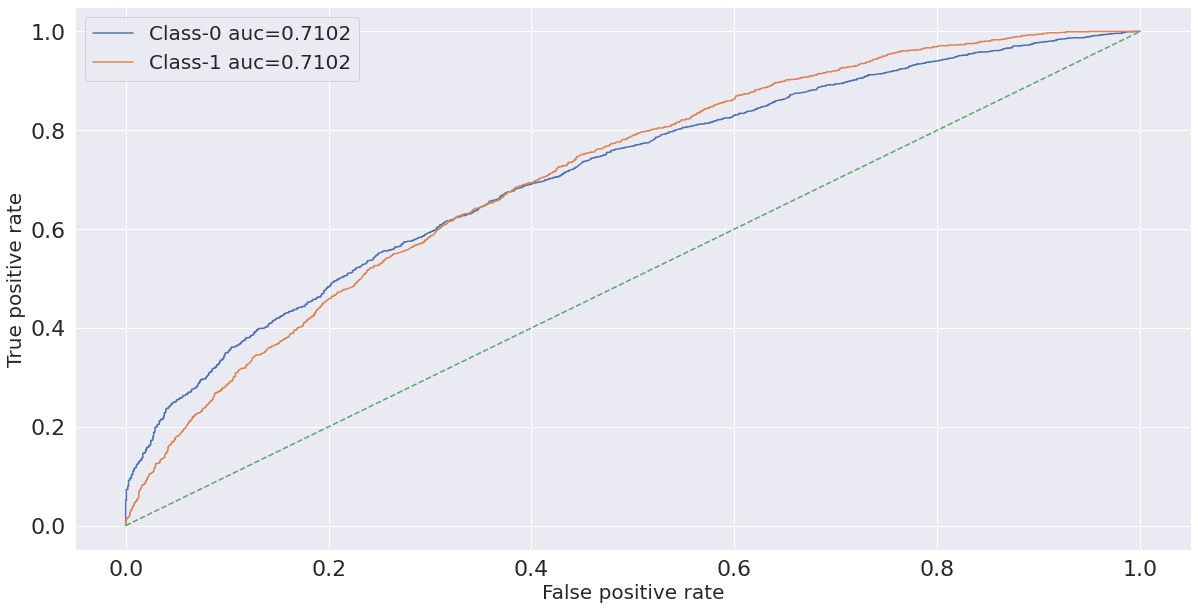

In [43]:
tpr_1, fpr_1, fpr_2, tpr_2, y_pred, model,pipe, precision, recall = XgboostClassifier(X_test,y_test,X_smote,y_smote)
plt.figure(figsize=(20,10))
plt.plot(fpr_1,tpr_1,label='Class-0 auc='+str(round(auc(fpr_1,tpr_1),4)))
plt.plot(fpr_2,tpr_2,label='Class-1 auc='+str(round(auc(fpr_2,tpr_2),4)))
plt.legend(loc='best',fontsize=20)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--')

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

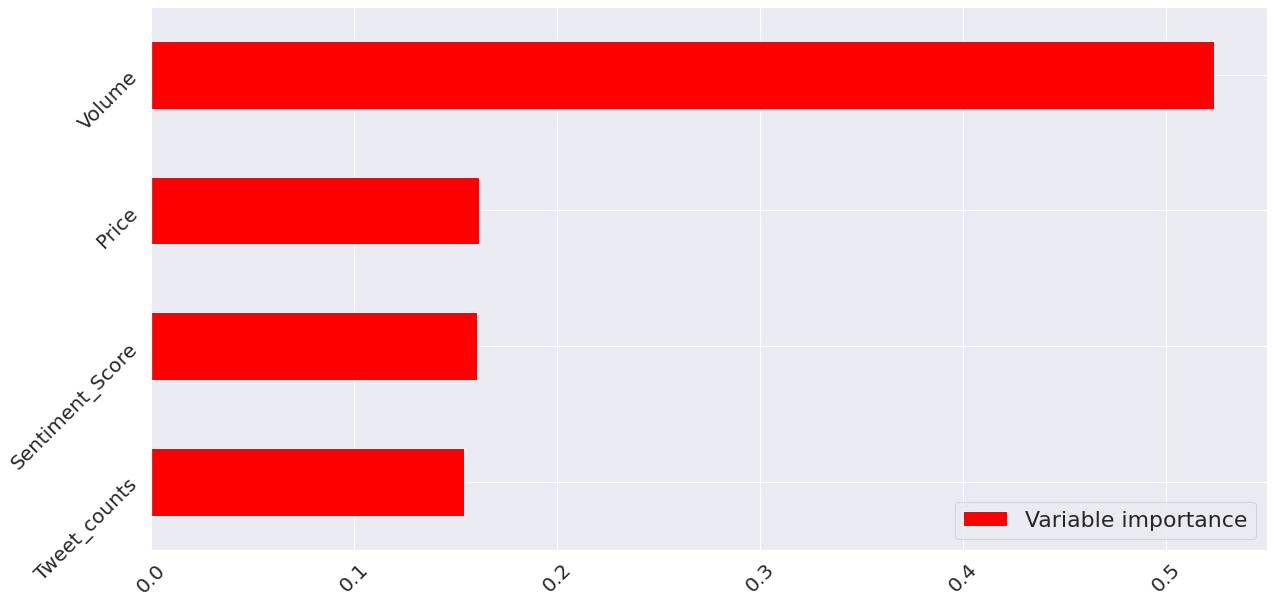

In [44]:
feature_names = list(df_xgboost.columns)

feature_names.remove('Indicator')

forest_importances = pd.DataFrame(model.feature_importances_, index=feature_names).rename(columns={0:'Variable importance'})
forest_importances[0:4].sort_values(by='Variable importance').plot(kind='barh',rot=0,color='red',figsize=(20,10))
plt.legend(loc='best')
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=45,fontsize=20)

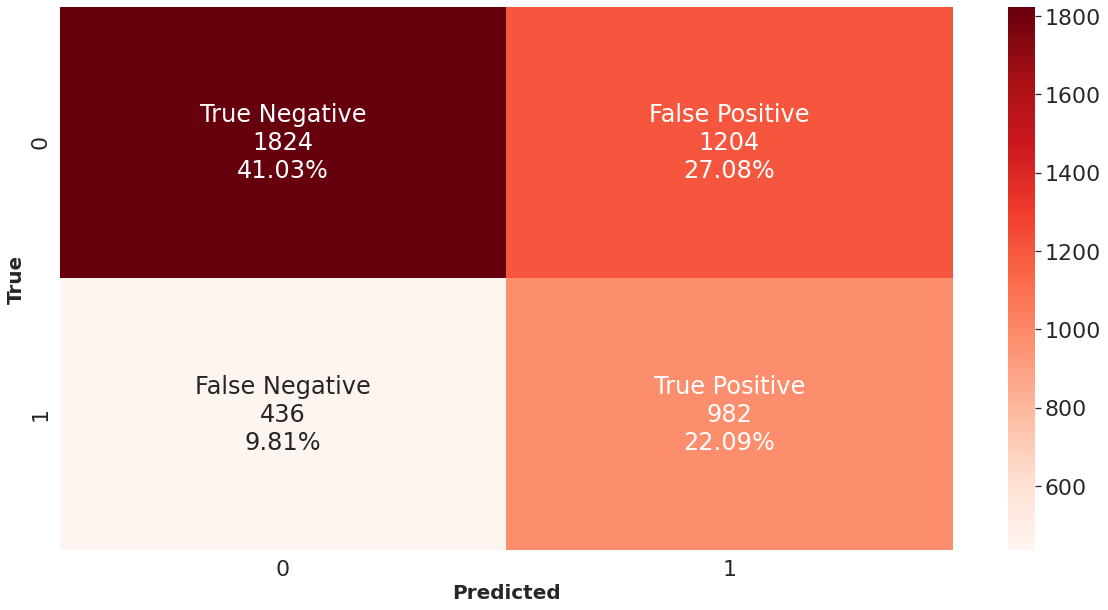

In [45]:



labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,y_pred)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(20,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()

## Have to add the numbers here and add the precision and recall curve too for the base classifier.

In [46]:
model = xgboost.sklearn.XGBClassifier()
model.get_params
##get defaults

<bound method XGBModel.get_params of XGBClassifier()>

In [47]:
params = {'learning_rate':[0.1,0.09,0.05,0.02],'max_depth':[2,3,4,5],'n_estimators':[100,200]} ## I am optimizing the XgBoost using the maximum depth and the learning rate. Hyper parameter tuning is an art.

model = xgboost.sklearn.XGBClassifier()

Output = predict_fit(model,6,params,'recall',X_smote,y_smote,X_test,y_test)

In [48]:
Output.keys()

dict_keys(['tpr_1', 'fpr_1', 'fpr_2', 'tpr_2', 'predictions', 'model', 'accuracy', 'precision', 'recall', 'feature_importance'])

(0.0, 1.0)

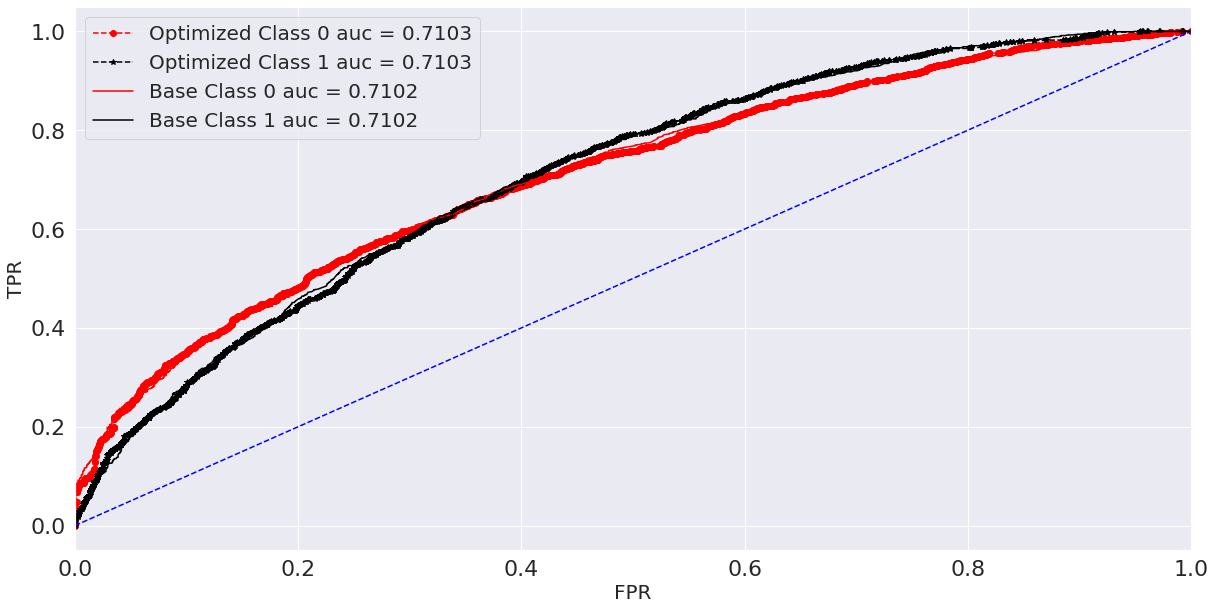

In [49]:
plt.figure(figsize=(20,10))
plt.plot(Output['fpr_1'],Output['tpr_1'],'--o',label='Optimized Class 0'+' '+'auc = '+str(round(auc(Output['fpr_1'],Output['tpr_1']),4)),color='red')
plt.plot(Output['fpr_2'],Output['tpr_2'],'--*',label='Optimized Class 1'+' '+'auc = '+str(round(auc(Output['fpr_2'],Output['tpr_2']),4)),color='black')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--',color='blue')
plt.plot(fpr_1,tpr_1,label='Base Class 0'+' '+'auc = '+str(round(auc(fpr_1,tpr_1),4)),color='red')
plt.plot(fpr_2,tpr_2,label='Base Class 1'+' '+'auc = '+str(round(auc(fpr_2,tpr_2),4)),color='black')
plt.legend(loc='best',fontsize=20)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
plt.xlim(0,1)


(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

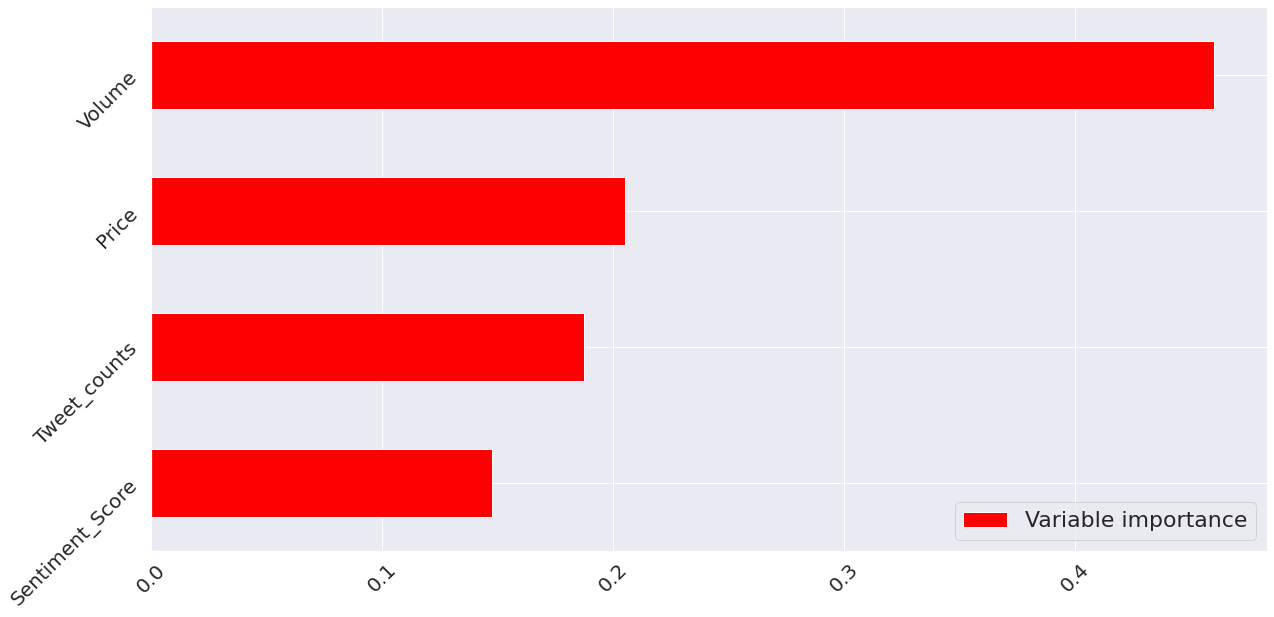

In [50]:

feature_names = list(df_xgboost.columns)

feature_names.remove('Indicator')

forest_importances = pd.DataFrame((Output['model']).feature_importances_, index=feature_names).rename(columns={0:'Variable importance'})
forest_importances[0:4].sort_values(by='Variable importance').plot(kind='barh',rot=0,color='red',figsize=(20,10))
plt.legend(loc='best')
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=45,fontsize=20)

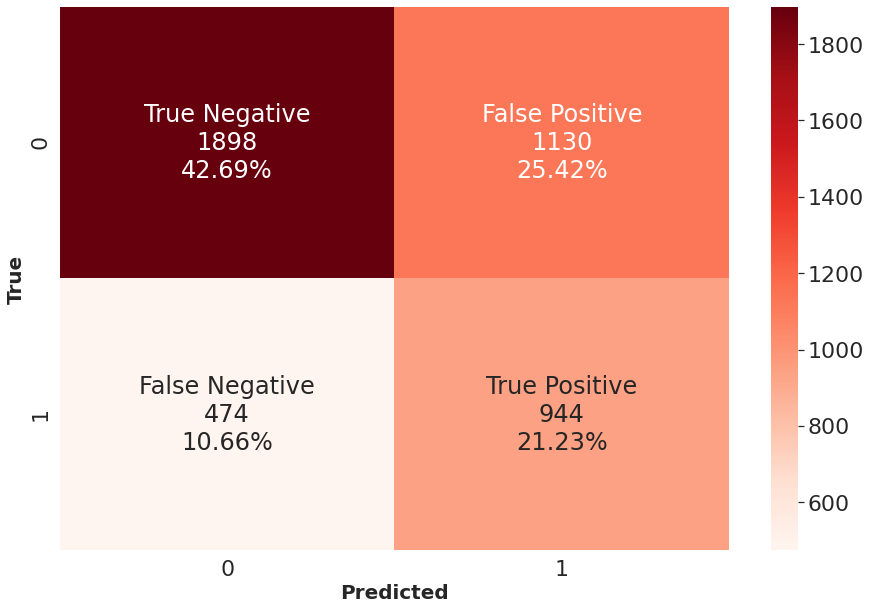

In [51]:


labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,Output['predictions'])
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(15,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')
plt.show()


In [52]:

explainer = shap.Explainer(Output['model'])
shap_values = explainer(X_smote)

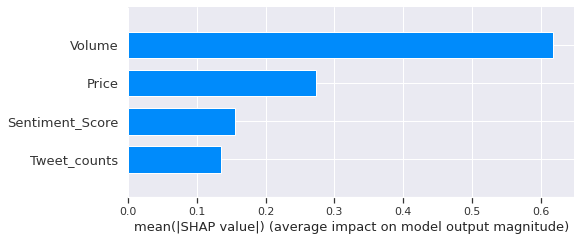

In [53]:

shap.summary_plot(shap_values, X_smote, plot_type="bar",plot_size=0.5)

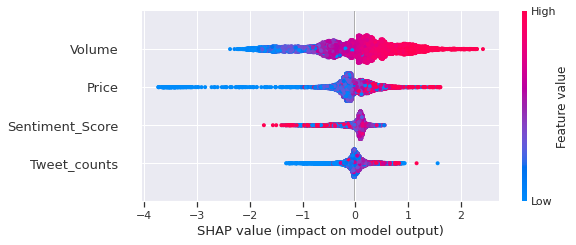

In [54]:

shap.plots.beeswarm(shap_values,plot_size=0.5)

## I will try one more model quickly to check if the XgBoost is giving unecessary weight to those features identified as important by it.

In [55]:
lightgbm = setup(data = df_new, target = 'Indicator',fix_imbalance=True)

Description             Value
0                               session_id              2149
1                                   Target         Indicator
2                              Target Type            Binary
3                            Label Encoded    0.0: 0, 1.0: 1
4                            Original Data        (14819, 5)
5                           Missing Values             False
6                         Numeric Features                 4
7                     Categorical Features                 0
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set        (10373, 4)
12                    Transformed Test Set         (4446, 4)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              d33d
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection             False
52                Feature Selection Method           classic
53            Features Selection Threshold              None
54                     Feature Interaction             False
55                           Feature Ratio             False
56                   Interaction Threshold              None
57                           Fix Imbalance              True
58                    Fix Imbalance Method             SMOTE

In [56]:
lgbm = create_model('lightgbm')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.6657  0.7031  0.6215  0.4742  0.5379  0.2834  0.2898
1       0.6387  0.7118  0.6092  0.4439  0.5136  0.2374  0.2449
2       0.6551  0.7082  0.6104  0.4628  0.5265  0.2632  0.2695
3       0.6606  0.7040  0.6400  0.4695  0.5417  0.2821  0.2906
4       0.6278  0.6897  0.6308  0.4352  0.5151  0.2292  0.2396
5       0.6384  0.6924  0.5815  0.4416  0.5020  0.2264  0.2317
6       0.6548  0.7025  0.6154  0.4619  0.5277  0.2643  0.2710
7       0.6548  0.7034  0.6215  0.4622  0.5302  0.2665  0.2738
8       0.6567  0.7183  0.6708  0.4668  0.5505  0.2870  0.2993
9       0.6606  0.7330  0.6892  0.4716  0.5600  0.2992  0.3135
Mean    0.6513  0.7066  0.6290  0.4590  0.5305  0.2639  0.2724
SD      0.0115  0.0118  0.0296  0.0130  0.0168  0.0241  0.0256

In [57]:
tune_lgbm = tune_model(lgbm,optimize='Recall')


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.5915  0.6871  0.7538  0.4160  0.5361  0.2223  0.2540
1       0.6435  0.6803  0.5692  0.4458  0.5000  0.2294  0.2335
2       0.5809  0.6719  0.7454  0.4084  0.5277  0.2051  0.2356
3       0.6075  0.6755  0.7292  0.4263  0.5380  0.2357  0.2616
4       0.5853  0.6558  0.6985  0.4061  0.5136  0.1942  0.2161
5       0.5612  0.6601  0.7446  0.3941  0.5154  0.1789  0.2097
6       0.6152  0.6650  0.6123  0.4216  0.4994  0.2038  0.2132
7       0.6123  0.6664  0.6338  0.4213  0.5061  0.2079  0.2197
8       0.6066  0.6903  0.7538  0.4276  0.5457  0.2428  0.2735
9       0.6509  0.7102  0.7077  0.4628  0.5596  0.2909  0.3089
Mean    0.6055  0.6763  0.6948  0.4230  0.5242  0.2211  0.2426
SD      0.0261  0.0155  0.0630  0.0188  0.0194  0.0298  0.0303

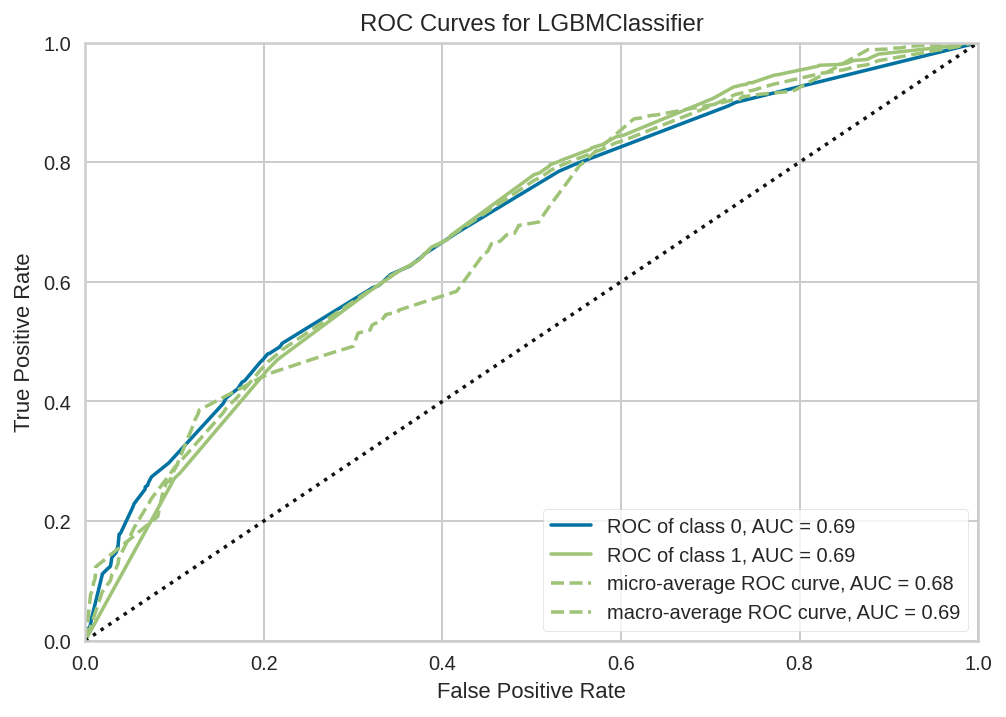

In [58]:
plot_model(tune_lgbm,plot='auc',scale=2)

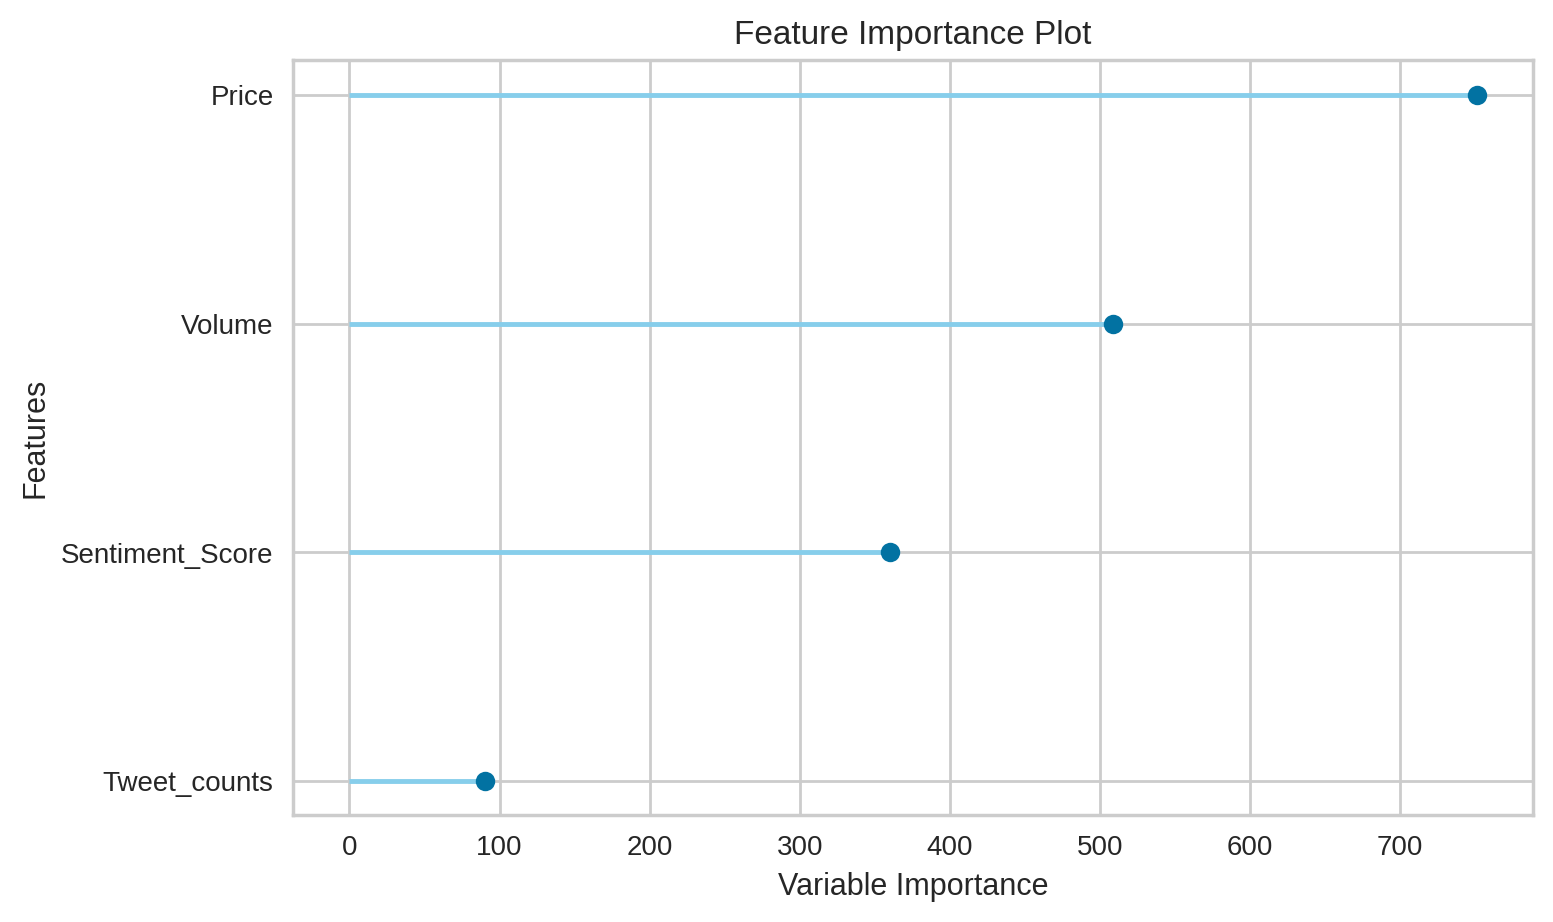

In [59]:
plot_model(tune_lgbm,scale=2,plot='feature')

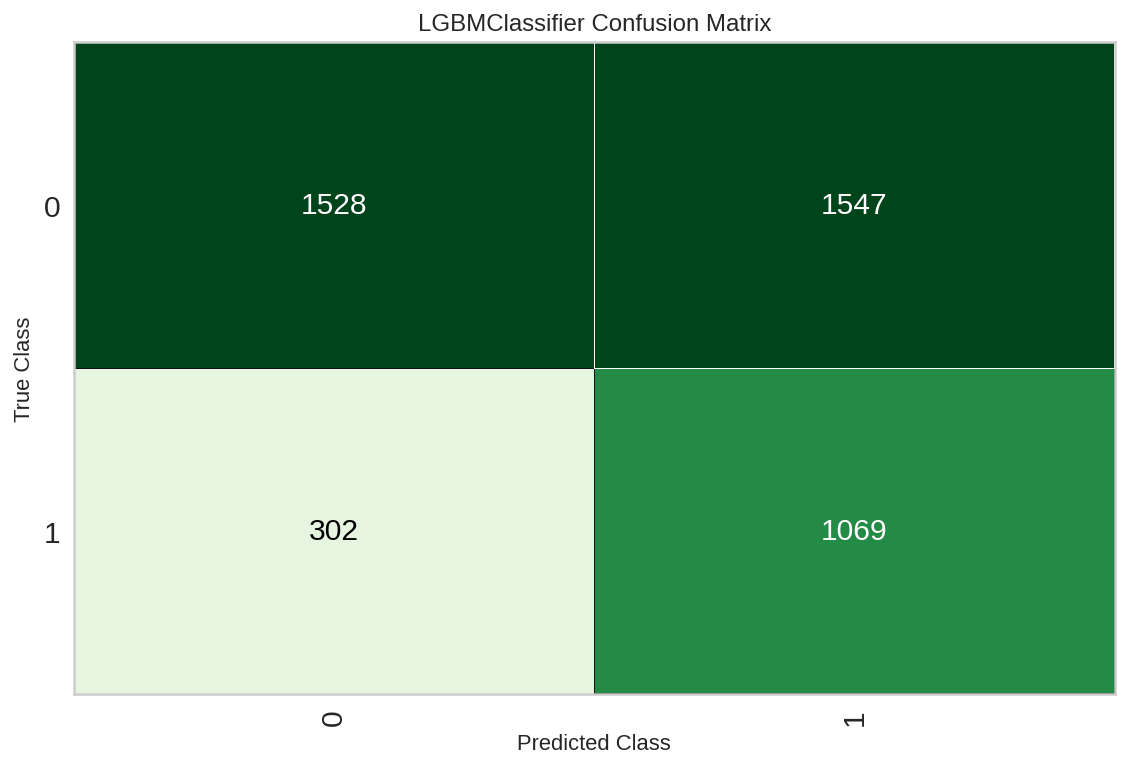

In [60]:
plot_model(tune_lgbm,plot='confusion_matrix',scale=2)

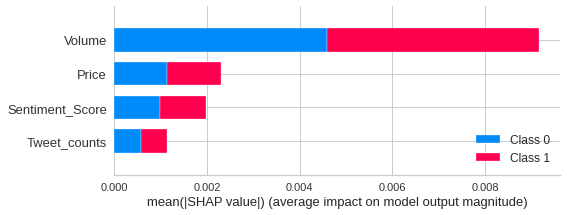

In [61]:
interpret_model(tune_lgbm)

## For the relatively optimized XgBoost model SHAP values indicates that the trade volume feature has the highest positive impact in the model output--i.e. in classifying the pumped stock. This is followed by stock price, tweet counts and the sentiment score. Therefore, the hypothesis (obvious) I made that the sentiment score contributes towards the pump and dump scheme seems to be relatively true as it was given a higher weight at least by two models i.e. XgBoost and Light gradient boost.

## I will now explore some more advanced features. The link to the feature engineering notebook--where I processed them is here [link to notebook](https://github.com/abhinavgairola/Anomaly_Detection_OTC_Market/blob/main/Scripts/Feature_Engineering.ipynb)

In [65]:
more_feature= pd.read_parquet('/content/drive/MyDrive/OTCMKT/Feature_engineered.parquet.gzip')

In [66]:
more_feature = more_feature.drop(['Price','Volume','Ticker','Corpus','Enteties'],axis=1).set_index('Date')

In [67]:
more_feature

Indicator  Sentiment_Score  ...  Frequencies_MONEY  Frequencies_EVENT
Date                                    ...                                      
2016-09-16        0.0         0.357143  ...                0.0                0.0
2016-09-20        0.0         0.654397  ...                0.0               11.0
2016-09-21        0.0         0.293478  ...                0.0                3.0
2016-09-22        0.0         0.189573  ...                0.0                2.0
2016-09-29        0.0         0.236994  ...                0.0                0.0
...               ...              ...  ...                ...                ...
2016-05-24        0.0         0.336735  ...                0.0                0.0
2016-05-27        0.0         0.198347  ...                0.0                0.0
2016-05-31        0.0         0.348485  ...                3.0                0.0
2016-06-01        1.0         0.646018  ...                3.0                0.0
2016-06-24        0.0         0.423729  ...                0.0                0.0

[14819 rows x 9 columns]

In [68]:
columns_features = list(more_feature.columns)
columns_features.remove('Indicator')

In [69]:
x = more_feature[columns_features].values 
Minmax_scaler = preprocessing.MinMaxScaler()# scale to 0 and 1
x_scaled = Minmax_scaler.fit_transform(x)
#x_scaled_transform = Standard_scaler.fit_transform(x_scaled)
df_new_feature = pd.DataFrame(x_scaled)
df_new_feature.columns = columns_features

In [70]:
df_new_feature['Indicator'] = ''
df_new_feature['Indicator'] = list(more_feature.Indicator.values)

In [71]:
df_new_feature

Sentiment_Score  Tweet_counts  ...  Frequencies_EVENT  Indicator
0             0.667164      0.011490  ...           0.000000        0.0
1             0.821066      0.065732  ...           0.041667        0.0
2             0.634202      0.014194  ...           0.011364        0.0
3             0.580405      0.018756  ...           0.007576        0.0
4             0.604957      0.012335  ...           0.000000        0.0
...                ...           ...  ...                ...        ...
14814         0.656598      0.032781  ...           0.000000        0.0
14815         0.584948      0.044441  ...           0.000000        0.0
14816         0.662681      0.050017  ...           0.000000        0.0
14817         0.816727      0.097668  ...           0.000000        1.0
14818         0.701638      0.013011  ...           0.000000        0.0

[14819 rows x 9 columns]

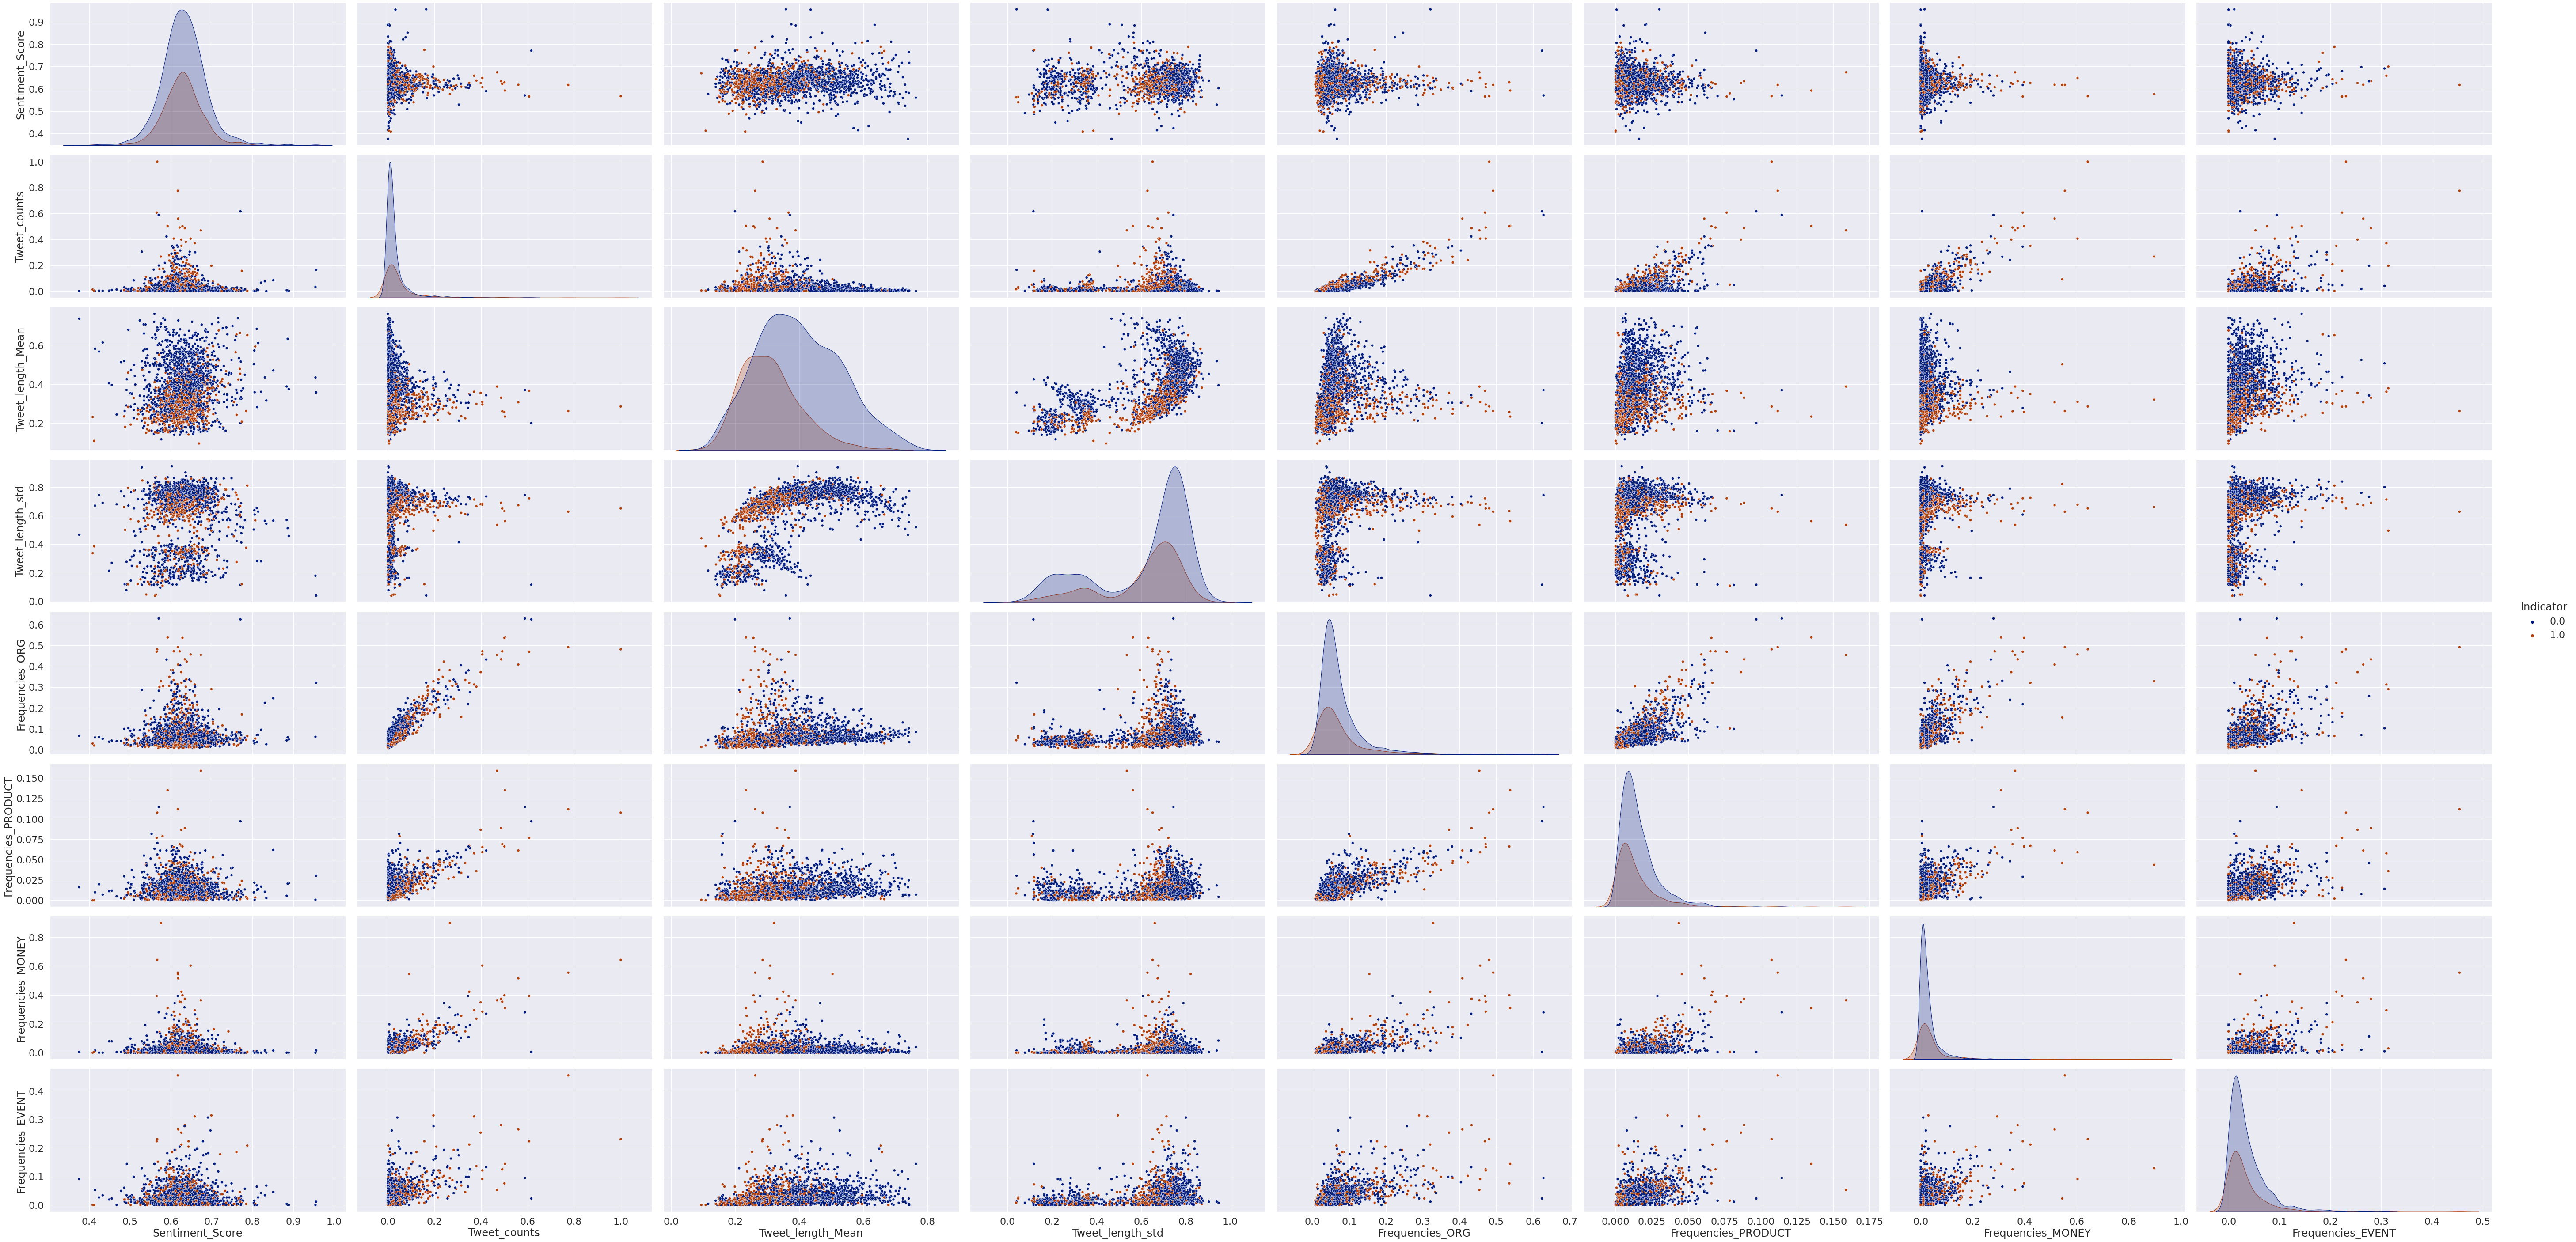

In [94]:
sns.set(font_scale = 2)
sns.pairplot(df_new_feature[0:2000], hue='Indicator',height=5, 
    aspect=2,palette='dark')

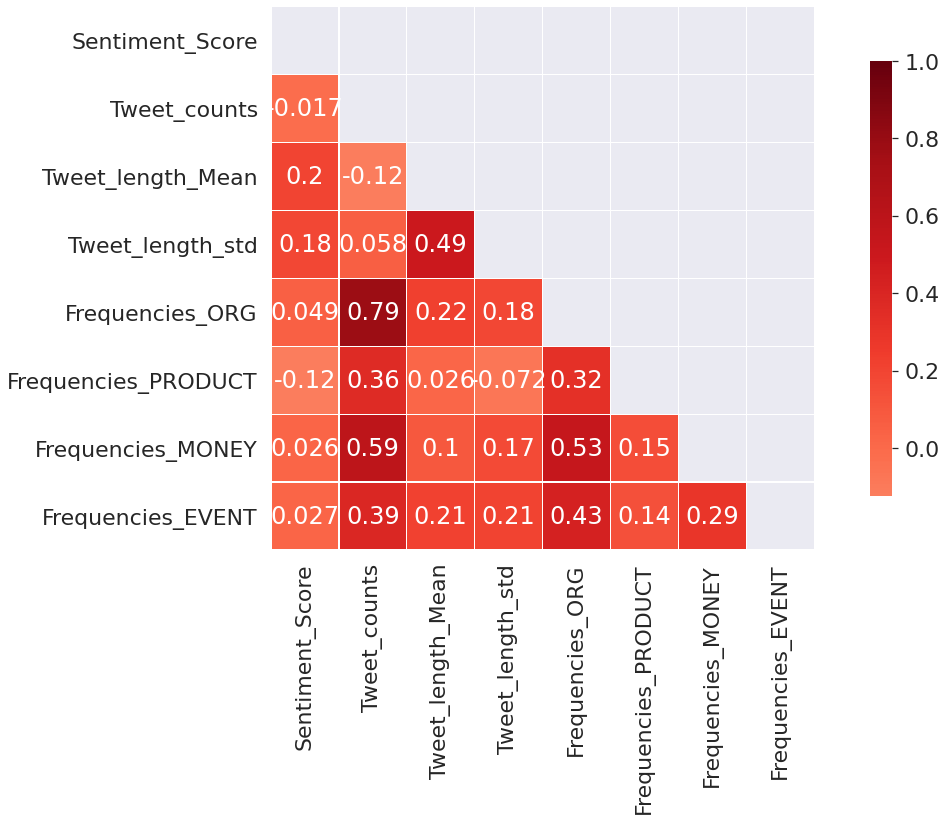

In [73]:
corr_2 = df_new_feature.drop('Indicator',axis=1).corr(method='pearson')
mask = np.triu(np.ones_like(corr_2, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize = (20,10))
sns.heatmap(corr_2, mask=mask, cmap='Reds', vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True,)

In [75]:
df_for_ml = df_new_feature #pd.get_dummies(df_new)
y = df_for_ml.Indicator
columns_x = list(df_for_ml.columns)
columns_x.remove('Indicator')
X = df_for_ml[columns_x]

sm = SMOTE(random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

X_smote, y_smote = sm.fit_resample(X_train, y_train)

In [78]:
model_lr = LogisticRegression()
lr_params = {'penalty':['elasticnet'],'random_state':[0],'max_iter':[1000],'solver':['saga'],'l1_ratio':[0.1]}
Output_lr = predict_fit(model_lr,6,lr_params,'recall',X_smote,y_smote,X_test,y_test) 
#grid.fit(X_smote, y_smote)
dir(model_lr)
((type(model_lr)).__name__)
Output_lr.keys()
y_pred_lr = Output_lr['model'].predict(X_test)
proba_lr = Output_lr['model'].predict_proba(X_test)
tpr_1_lr, fpr_1_lr, threshold_1_lr = roc_curve(y_test, proba_lr[:,0])
fpr_2_lr, tpr_2_lr, threshold_2_lr = roc_curve(y_test, proba_lr[:,1])

Text(0, 0.5, 'True positive rate')

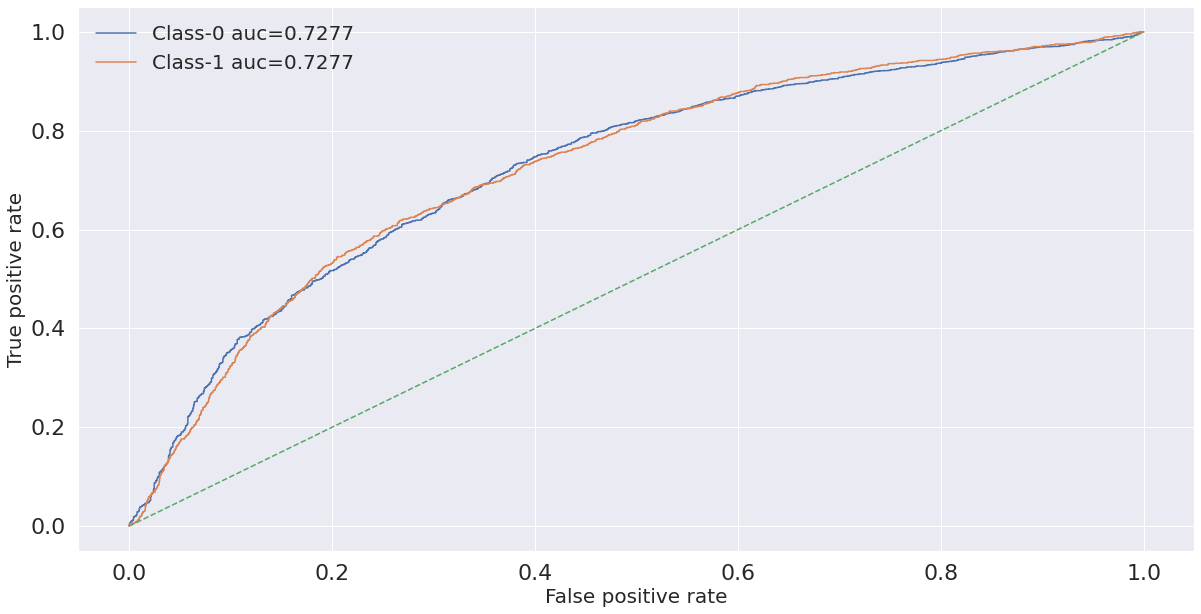

In [85]:
#tpr_1, fpr_1, fpr_2, tpr_2, y_pred, model,pipe, precision, recall = XgboostClassifier(X_test,y_test,X_smote,y_smote)
plt.figure(figsize=(20,10))
plt.plot(fpr_1_lr,tpr_1_lr,label='Class-0 auc='+str(round(auc(fpr_1_lr,tpr_1_lr),4)))
plt.plot(fpr_2_lr,tpr_2_lr,label='Class-1 auc='+str(round(auc(fpr_2_lr,tpr_2_lr),4)))
plt.legend(loc='best',fontsize=20)
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--')

plt.xlabel('False positive rate', fontsize=20)
plt.ylabel('True positive rate', fontsize=20)

Text(143.0, 0.5, 'True')

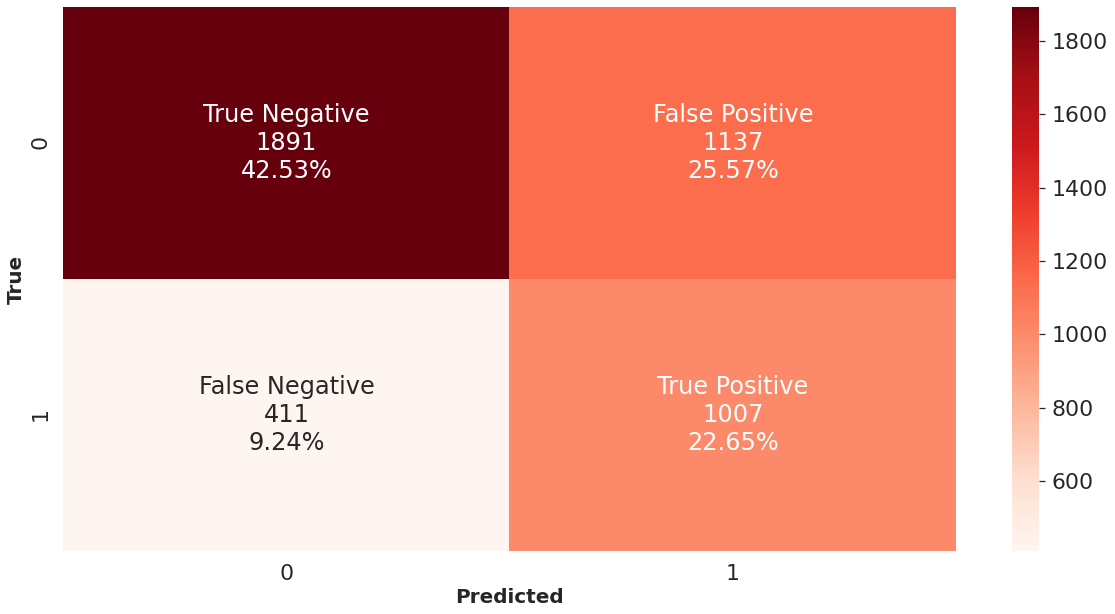

In [86]:
labels = ['True Negative','False Positive','False Negative','True Positive']
cf_matrix = confusion_matrix(y_test,y_pred_lr)
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                    cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(labels,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize=(20,10))
sns.heatmap(cf_matrix,annot=labels,fmt='',cmap='Reds',cbar=True)
plt.xlabel(r'Predicted',fontsize=20,fontweight='bold')
plt.ylabel(r'True',fontsize=20,fontweight='bold')

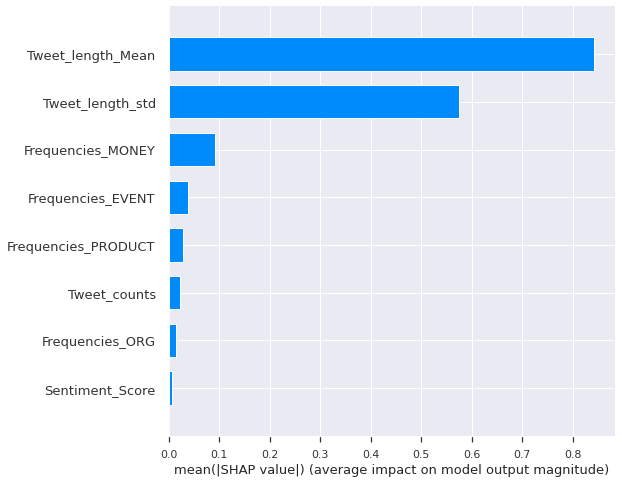

In [81]:
explainer = shap.LinearExplainer(Output_lr['model'],X_smote)#, X_train, feature_dependence="independent")
Shap_values = explainer(X_test)
shap.summary_plot(Shap_values, X_smote, plot_type="bar",plot_size=0.8)

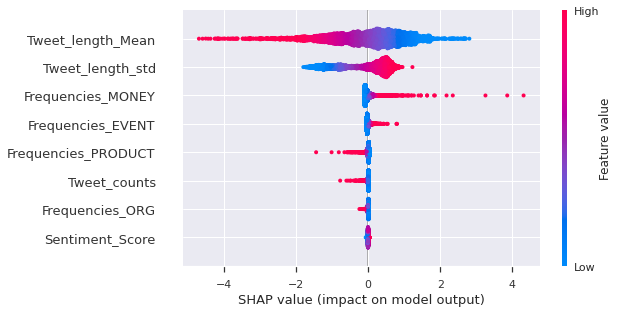

In [82]:
shap.plots.beeswarm(Shap_values)

In [87]:
params = {'learning_rate':[0.1,0.09,0.05,0.02],'max_depth':[2,3,4,5],'n_estimators':[100,200]} ## I am optimizing the XgBoost using the maximum depth and the learning rate. Hyper parameter tuning is an art.

model = xgboost.sklearn.XGBClassifier()

Output = predict_fit(model,6,params,'recall',X_smote,y_smote,X_test,y_test)

(0.0, 1.0)

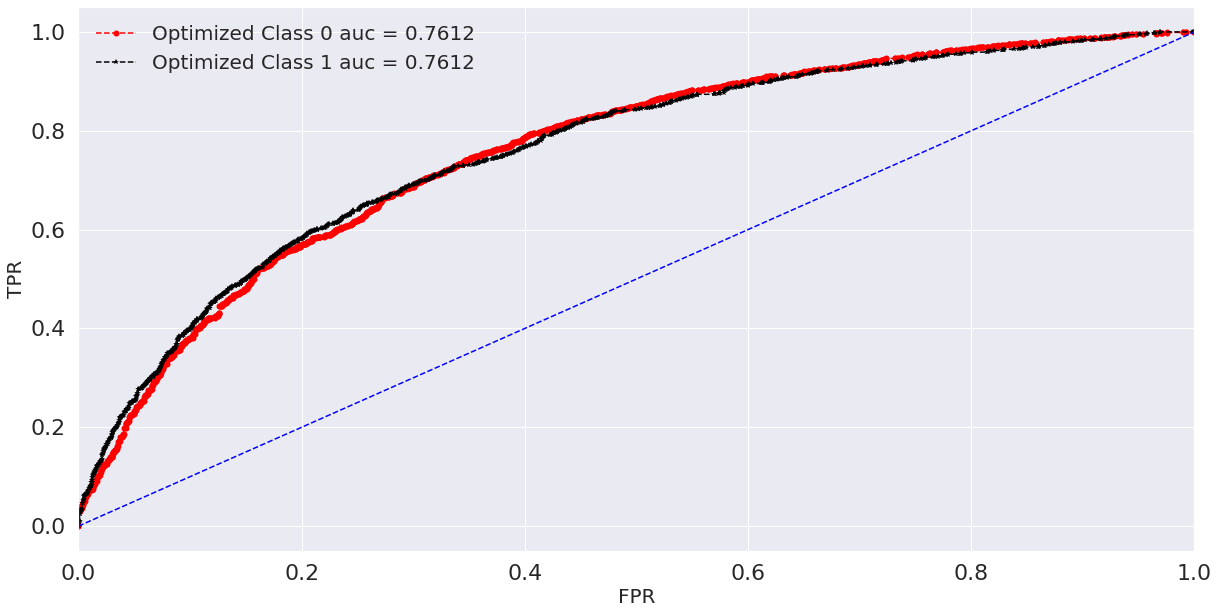

In [88]:
plt.figure(figsize=(20,10))
plt.plot(Output['fpr_1'],Output['tpr_1'],'--o',label='Optimized Class 0'+' '+'auc = '+str(round(auc(Output['fpr_1'],Output['tpr_1']),4)),color='red')
plt.plot(Output['fpr_2'],Output['tpr_2'],'--*',label='Optimized Class 1'+' '+'auc = '+str(round(auc(Output['fpr_2'],Output['tpr_2']),4)),color='black')
plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1),'--',color='blue')
#plt.plot(fpr_1,tpr_1,label='Base Class 0'+' '+'auc = '+str(round(auc(fpr_1,tpr_1),4)),color='red')
#plt.plot(fpr_2,tpr_2,label='Base Class 1'+' '+'auc = '+str(round(auc(fpr_2,tpr_2),4)),color='black')
plt.legend(loc='best',fontsize=20)
plt.xlabel('FPR',fontsize=20)
plt.ylabel('TPR',fontsize=20)
plt.xlim(0,1)

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

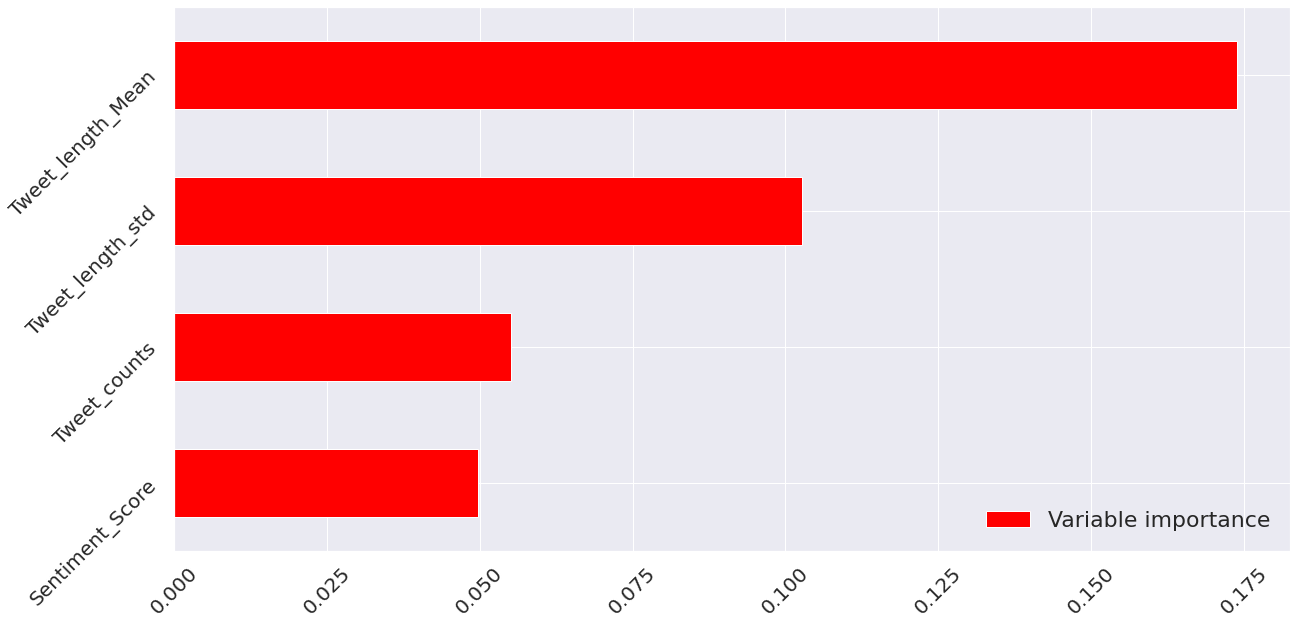

In [89]:
feature_names = list(df_for_ml.columns)

feature_names.remove('Indicator')

forest_importances = pd.DataFrame((Output['model']).feature_importances_, index=feature_names).rename(columns={0:'Variable importance'})
forest_importances[0:4].sort_values(by='Variable importance').plot(kind='barh',rot=0,color='red',figsize=(20,10))
plt.legend(loc='best')
plt.xticks(rotation=45,fontsize=20)
plt.yticks(rotation=45,fontsize=20)

In [90]:
explainer = shap.Explainer(Output['model'])
shap_values = explainer(X_smote)

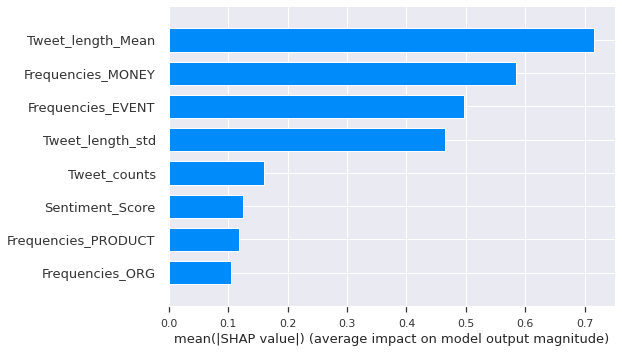

In [91]:
shap.summary_plot(shap_values, X_smote, plot_type="bar",plot_size=0.5)

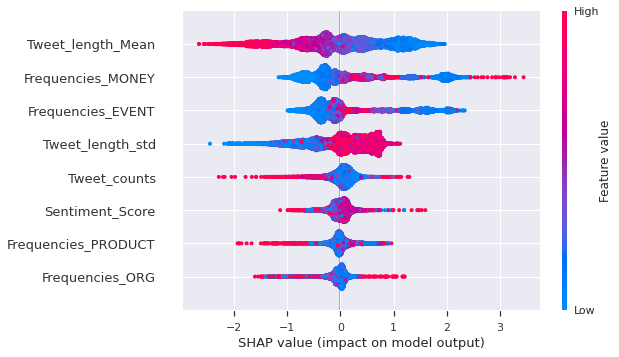

In [92]:
shap.plots.beeswarm(shap_values,plot_size=0.5)

In [106]:
df_new_feature

Sentiment_Score  Tweet_counts  ...  Frequencies_EVENT  Indicator
0             0.667164      0.011490  ...           0.000000        0.0
1             0.821066      0.065732  ...           0.041667        0.0
2             0.634202      0.014194  ...           0.011364        0.0
3             0.580405      0.018756  ...           0.007576        0.0
4             0.604957      0.012335  ...           0.000000        0.0
...                ...           ...  ...                ...        ...
14814         0.656598      0.032781  ...           0.000000        0.0
14815         0.584948      0.044441  ...           0.000000        0.0
14816         0.662681      0.050017  ...           0.000000        0.0
14817         0.816727      0.097668  ...           0.000000        1.0
14818         0.701638      0.013011  ...           0.000000        0.0

[14819 rows x 9 columns]

In [ ]:
%%shell
jupyter nbconvert --to html /content/EDA_Machine_learning.ipynb